# EECS 253 Final Project - Justin Leong

## Imports

In [ ]:
#The usual preamble
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

import seaborn as sns
import tensorflow as tf
from scipy import signal

from sklearn.decomposition import FastICA, PCA
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#for your homework
np.random.seed(50869362)
tf.random.set_seed(50869362)

## Data

In [ ]:
# mount from drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Note: Data can be found at https://archive.ics.uci.edu/dataset/360/air+quality

In [ ]:
# load data
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AirQualityUCI.csv', sep=';', decimal=',')
df.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578,NaN,NaN
1,10/03/2004,19.00.00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255,NaN,NaN
2,10/03/2004,20.00.00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502,NaN,NaN
3,10/03/2004,21.00.00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867,NaN,NaN
4,10/03/2004,22.00.00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888,NaN,NaN


In [ ]:
# Data Cleaning + Preprocessing

df = df.iloc[:, :-2] # last two columns empty, remove
df = df.replace(-200, np.nan) # missing numbers, replace with NaN
df = df.interpolate(method='linear')

# Columns used for models
sensor_cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
sensors = df[sensor_cols].copy()
sensors.head()

/tmp/ipython-input-4199989119.py:5: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear')


,CO(GT),NMHC(GT),C6H6(GT),NOx(GT),NO2(GT)
0,2.6,150.0,11.9,166.0,113.0
1,2.0,112.0,9.4,103.0,92.0
2,2.2,88.0,9.0,131.0,114.0
3,2.2,80.0,9.2,172.0,122.0
4,1.6,51.0,6.5,131.0,116.0


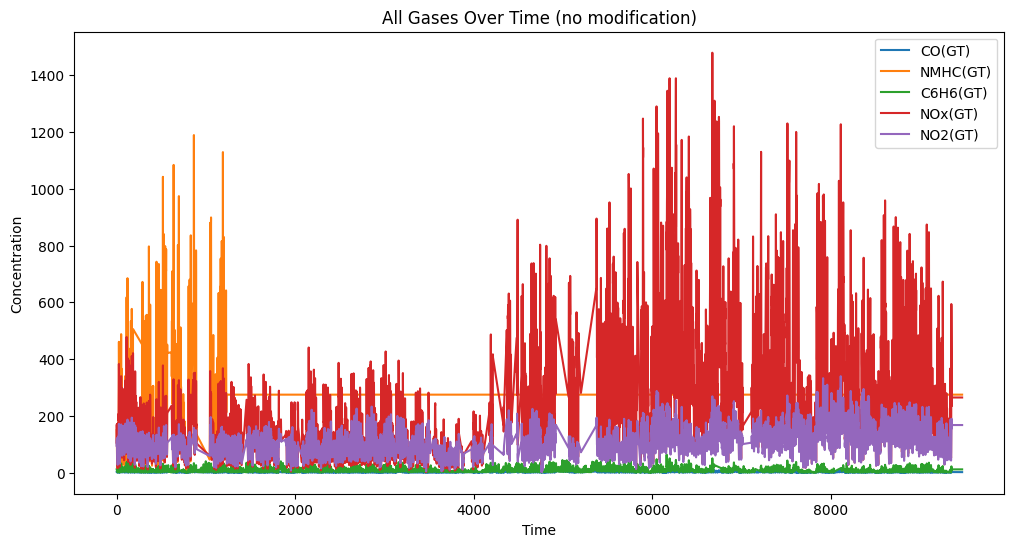

In [ ]:
plt.figure(figsize=(12,6))
for i in range(len(sensor_cols)):
  plt.plot(sensors[sensor_cols[i]], label=sensor_cols[i])
# plt.plot(sensors['CO(GT)'], label='CO(GT)')
plt.title("All Gases Over Time (no modification)")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.legend()
plt.show()

## PCA

Note: In this section I reference:
- Lecture 12
- Lecture 13
- https://www.geeksforgeeks.org/machine-learning/implementing-pca-in-python-with-scikit-learn/

In [ ]:
# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(sensors)

# Total variance before PCA
total_variance = np.sum(np.var(X_scaled, axis=0))
print("Total Variance Standard Data:", total_variance)

# PCA
pca = PCA(n_components=5)
X_pca = pca.fit_transform(X_scaled)

Total Variance Standard Data: 5.0


### PCA Plots

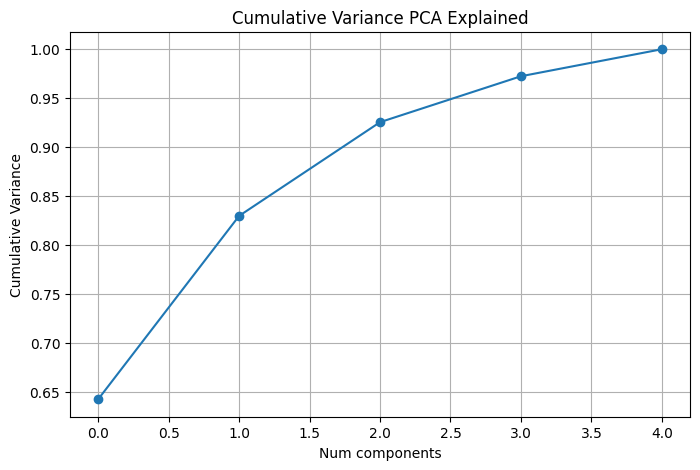

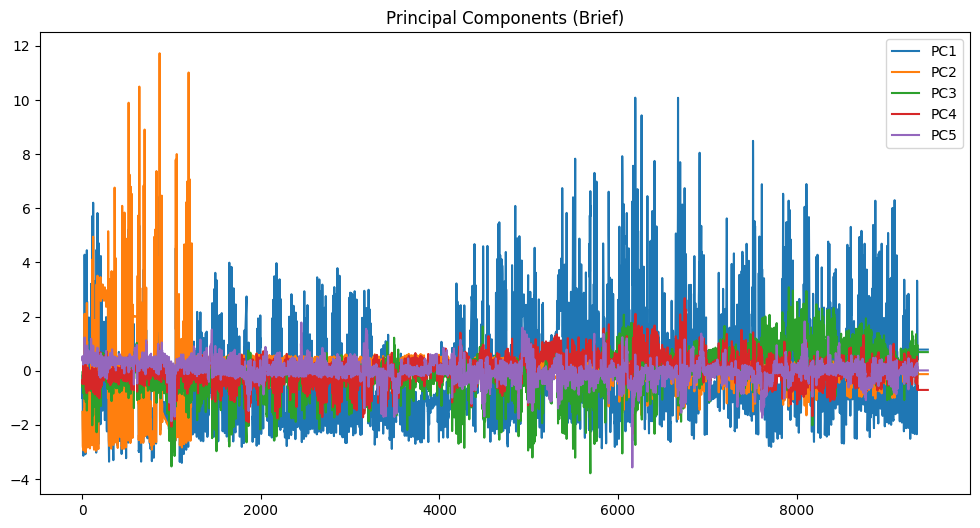

In [ ]:
# ---------------- Plots ------------------

# Variance plot
plt.figure(figsize=(8,5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Cumulative Variance PCA Explained")
plt.xlabel("Num components")
plt.ylabel("Cumulative Variance")
plt.grid(True)
plt.show()

# Components
plt.figure(figsize=(12,6))
plt.plot(X_pca[:,0], label='PC1')
plt.plot(X_pca[:,1], label='PC2')
plt.plot(X_pca[:,2], label='PC3')
plt.plot(X_pca[:,3], label='PC4')
plt.plot(X_pca[:,4], label='PC5')
plt.title("Principal Components (Brief)")
plt.legend()
plt.show()

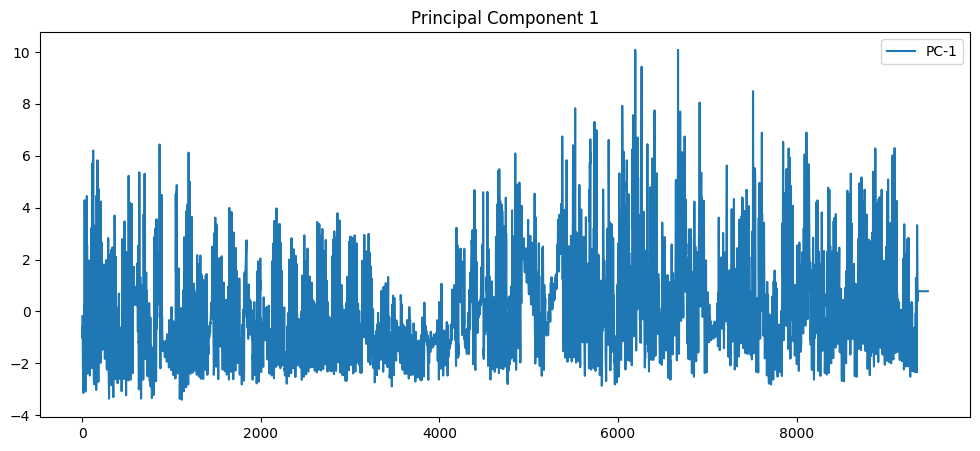

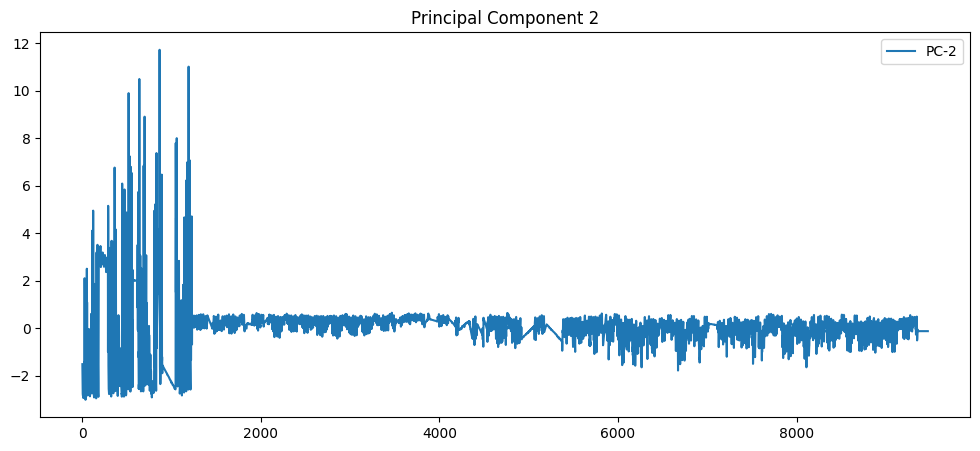

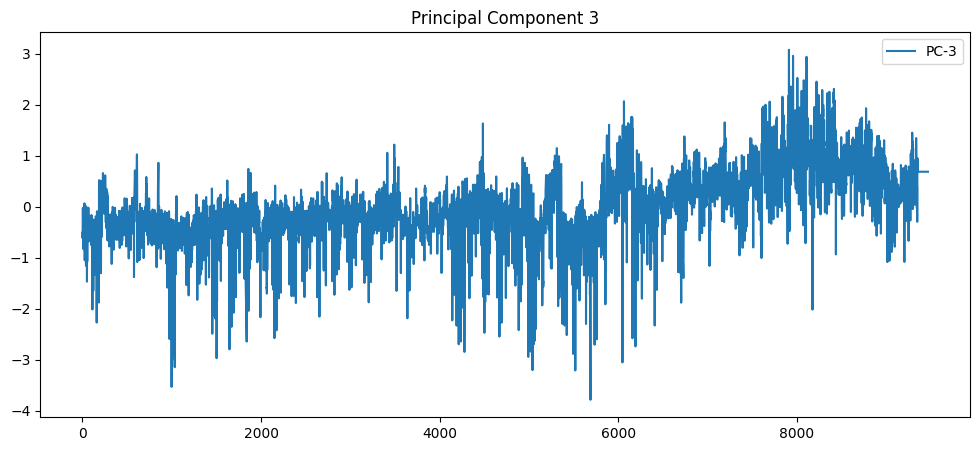

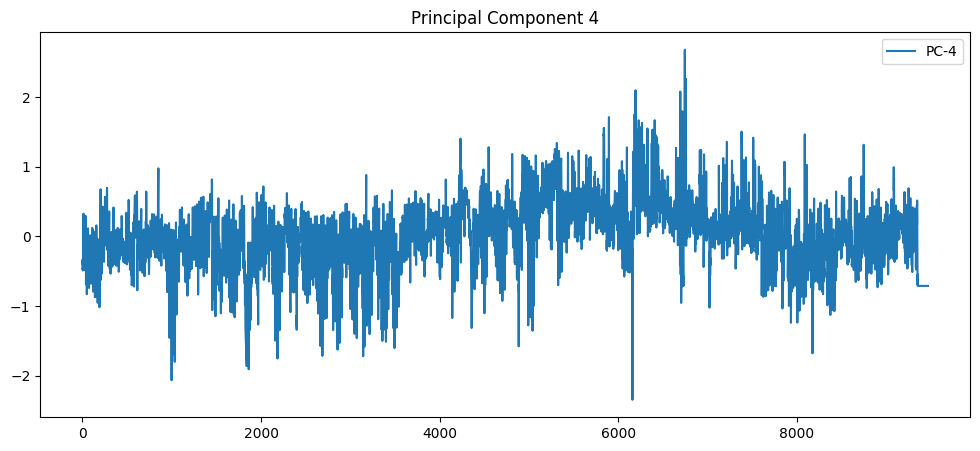

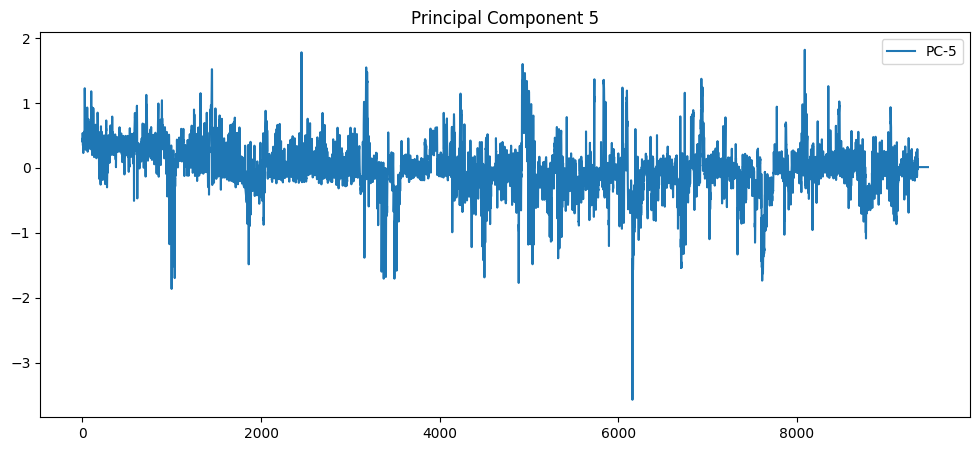

In [ ]:
# Components individual

# plt.figure(figsize=(12,6))
# plt.plot(X_pca[:,0], label='PC1')
# plt.plot(X_pca[:,1], label='PC2')
# plt.plot(X_pca[:,2], label='PC3')
# plt.plot(X_pca[:,3], label='PC4')
# plt.plot(X_pca[:,4], label='PC5')
# plt.title("Principal Components (Brief)")
# plt.legend()
# plt.show()

for i in range(0,5):
    plt.figure(figsize=(12,5))
    plt.plot(X_pca[:,i], label=f'PC-{i+1}')
    plt.title(f"Principal Component {i+1}")
    plt.legend()
    plt.show()

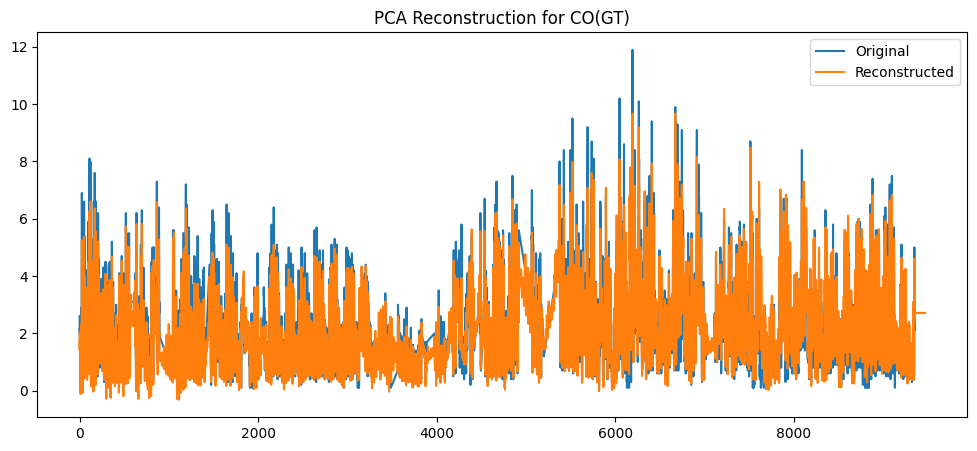

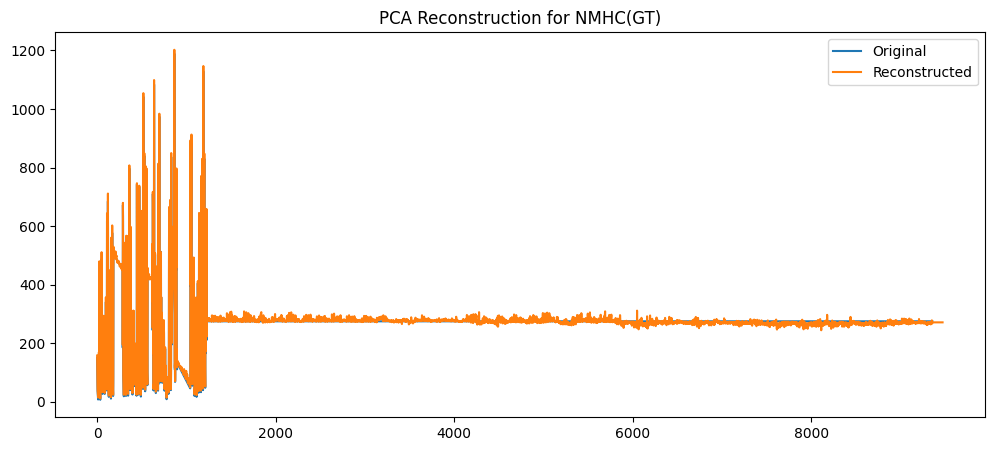

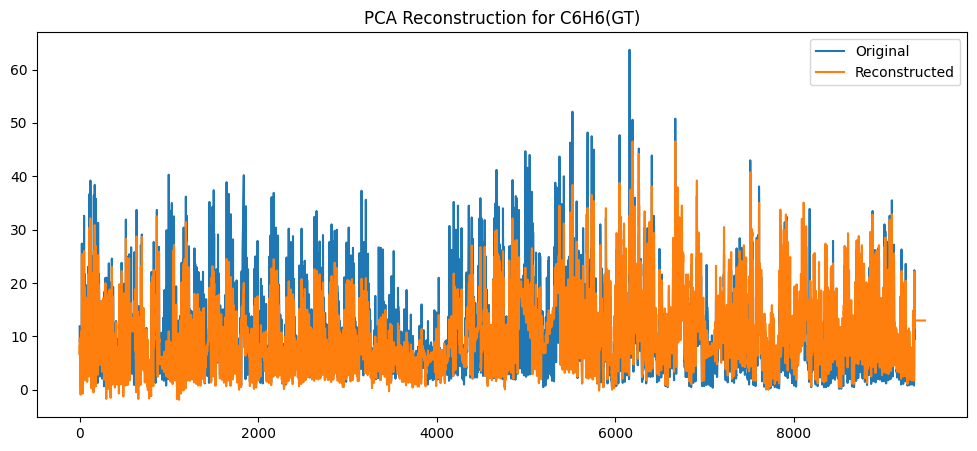

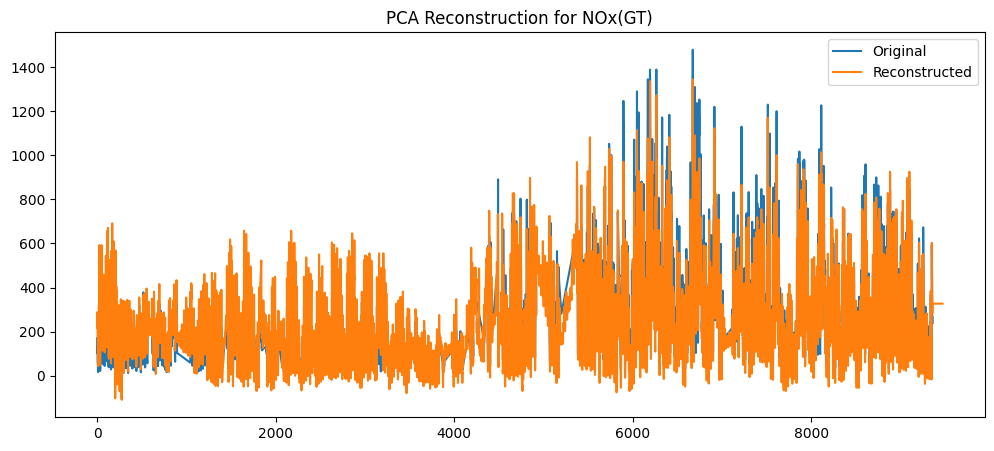

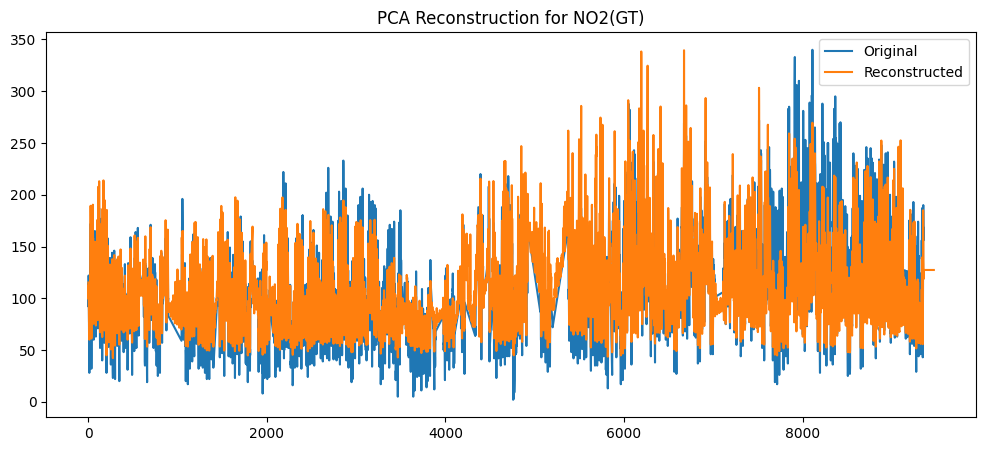

In [ ]:
# Reconstruct
N = 2
X_recon = X_pca[:, :N] @ pca.components_[:N, :]
X_recon = scaler.inverse_transform(X_recon)

# Compare
# plt.figure(figsize=(12,5))
# plt.plot(sensors['CO(GT)'].values, label='Original')
# plt.plot(X_recon[:,0], label=f'Reconstructed(PC-{N})')
# plt.title("PCA Reconstruction for CO(GT)")
# plt.legend()
# plt.show()

for i in range(0,5):
    plt.figure(figsize=(12,5))
    plt.plot(sensors[sensor_cols[i]].values, label='Original')
    plt.plot(X_recon[:,i], label=f'Reconstructed')
    plt.title(f"PCA Reconstruction for {sensor_cols[i]}")
    plt.legend()
    plt.show()

In [ ]:
print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Total explained variance ratio:", np.sum(pca.explained_variance_ratio_))
print("Explained variance:", pca.explained_variance_)

residual_variance = 1 - np.sum(pca.explained_variance_ratio_)
print("Residual variance:", residual_variance)

Explained variance ratio: [0.64236984 0.18733211 0.09575492 0.04692482 0.02761831]
Total explained variance ratio: 1.0
Explained variance: [3.21218836 0.93675946 0.47882518 0.23464885 0.13810614]
Residual variance: 0.0


### PCA Explanation
Above is a pretty accurate reconstruction for all PCA using only the first 2 principal component scores.This is to be expected as the majority of the variance will be found in the first two principal components, resulting in a somewhat accurate reconstruction.

## LSTM
Originally stated would use LMS but quickly realized that it wouldn't be good for this dataset as it is so long. LMS would be good on small portions but LSTM is just easier in this case.

Note: In this section I refer to:
- Lecture 10
- https://www.geeksforgeeks.org/deep-learning/long-short-term-memory-lstm-rnn-in-tensorflow/
- https://www.statology.org/how-to-build-lstm-models-for-time-series-prediction-in-python/


### Reinstate of imports + data

In [ ]:
# Same imports from earlier

# Had some issues with NMHC, added .dropna()
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/AirQualityUCI.csv', sep=';', decimal=',')
# df = df.interpolate().dropna()
df = df.iloc[:, :-2] # last two columns empty, remove
df = df.replace(-200, np.nan) # missing numbers, replace with NaN
df = df.interpolate(method='linear').dropna()

# Same sensor_cols
sensor_cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']

# Columns used for models
sensor_cols = ['CO(GT)', 'NMHC(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
sensors = df[sensor_cols].copy()

X = df[sensor_cols].values
y = df[sensor_cols].values

# Standardize again
scaler = StandardScaler()
X = scaler.fit_transform(X)
y = scaler.transform(y)

/tmp/ipython-input-911013374.py:8: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method='linear').dropna()


### Data

In [ ]:
# Need a way to split data, is slightly different from lecture (not timeseries of image)
# Sequence generator with "24" hour window
def create_sequences(X, y, window=24):
    X_seq, y_seq = [], []
    for i in range(len(X) - window):
        X_seq.append(X[i:i+window])
        y_seq.append(y[i+window])
    return np.array(X_seq), np.array(y_seq)

window = 24
X_seq, y_seq = create_sequences(X, y, window)

In [ ]:
split = int(0.8 * len(X_seq))
X_train = X_seq[:split]
X_test = X_seq[split:]
y_train = y_seq[:split]
y_test = y_seq[split:]

### LSTM Model

In [ ]:
model = Sequential([
    LSTM(64, return_sequences=False, input_shape=(window, X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(5, activation='linear')
])

model.compile(optimizer='adam', loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,165 (78.77 KB)

 Trainable params: 20,165 (78.77 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - loss: 0.6185 - val_loss: 0.2854
Epoch 2/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.2411 - val_loss: 0.2450
Epoch 3/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.2137 - val_loss: 0.2304
Epoch 4/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - loss: 0.1997 - val_loss: 0.2193
Epoch 5/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 14s 48ms/step - loss: 0.1912 - val_loss: 0.2144
Epoch 6/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - loss: 0.1817 - val_loss: 0.2126
Epoch 7/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 0.1740 - val_loss: 0.2143
Epoch 8/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.1662 - val_loss: 0.2152
Epoch 9/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 0.1596 - val_loss: 0.2112
Epoch 10/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - loss: 0.1538 - val_loss: 0.2076
Epoch 11/30
187/187 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - loss: 0.1493 - val_loss: 0.2044
Epoch 12/30
187/187 ━━━━━━━━━━━━━━━━━━━

<Axes: >

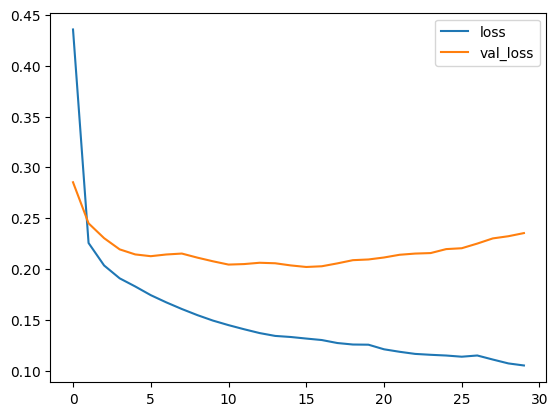

In [ ]:
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.2)
losses = pd.DataFrame(model.history.history)
losses.plot()

In [ ]:
# Prediction
y_pred_norm = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_norm)
y_true = scaler.inverse_transform(y_test)

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


### LSTM Plots

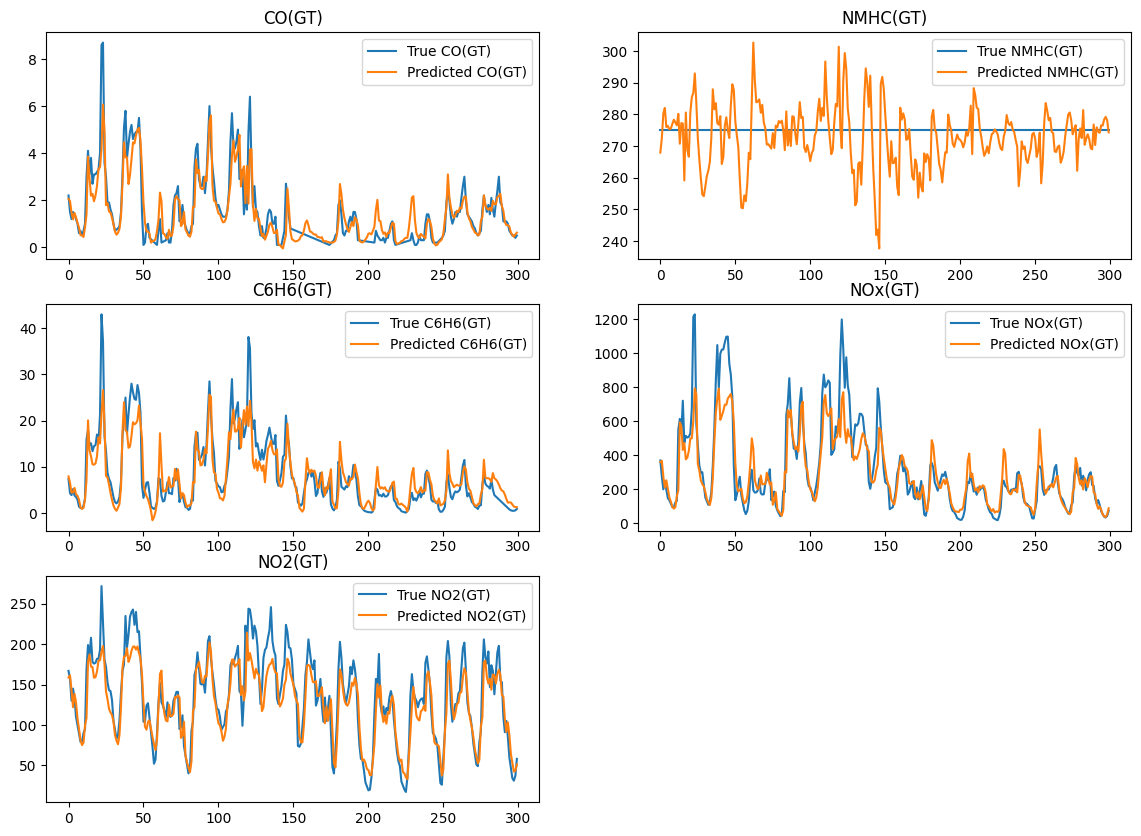

In [ ]:
plt.figure(figsize=(14,10))
for i, col in enumerate(sensor_cols):
    plt.subplot(3, 2, i+1)
    plt.plot(y_true[:300, i], label='True ' + col)
    plt.plot(y_pred[:300, i], label='Predicted ' + col)
    plt.title(col)
    plt.legend()
plt.show()

### LSTM MAE and Correlation

In [ ]:
from sklearn.metrics import mean_absolute_error

mae_per_sensor = {}
for i, col in enumerate(sensor_cols):
    mae = mean_absolute_error(y_true[:,i], y_pred[:,i])
    mae_per_sensor[col] = mae

print("MAE Per Sensor:")
for col, mae in mae_per_sensor.items():
    print(f"{col}: {mae}")

# Overall MAE
overall_mae = mean_absolute_error(y_true, y_pred)
print("\nOverall MAE:", overall_mae)

MAE Per Sensor:
CO(GT): 0.46549558004066666
NMHC(GT): 7.028173682647525
C6H6(GT): 2.1323514060126203
NOx(GT): 68.8405007330185
NO2(GT): 20.418689275209317

Overall MAE: 19.777042135385727


In [ ]:
from scipy.stats import pearsonr

corr_per_sensor = {}
for i, col in enumerate(sensor_cols):
    corr, _ = pearsonr(y_true[:,i], y_pred[:,i])
    corr_per_sensor[col] = corr

print("\nCorrelation Per Sensor:")
for col, corr in corr_per_sensor.items():
    print(f"{col}: {corr}")


Correlation Per Sensor:
CO(GT): 0.8806437367414424
NMHC(GT): nan
C6H6(GT): 0.878989825101447
NOx(GT): 0.8734744295486273
NO2(GT): 0.8960017910583652


/tmp/ipython-input-2454904619.py:5: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(y_true[:,i], y_pred[:,i])


### LSTM Explanation

In general, we can clearly see that LSTM is quite a good predictor. The model's predictions was really accurate to show in the portion of test set I decided to utilize. Unfortunately NMHC(GT) doesn't have a good prediction purely becacuse at some certain time point in the original data, it just becomes "-200" or NaN after data processing. As such, we cannot judge that prediction as there is no proper data for it.

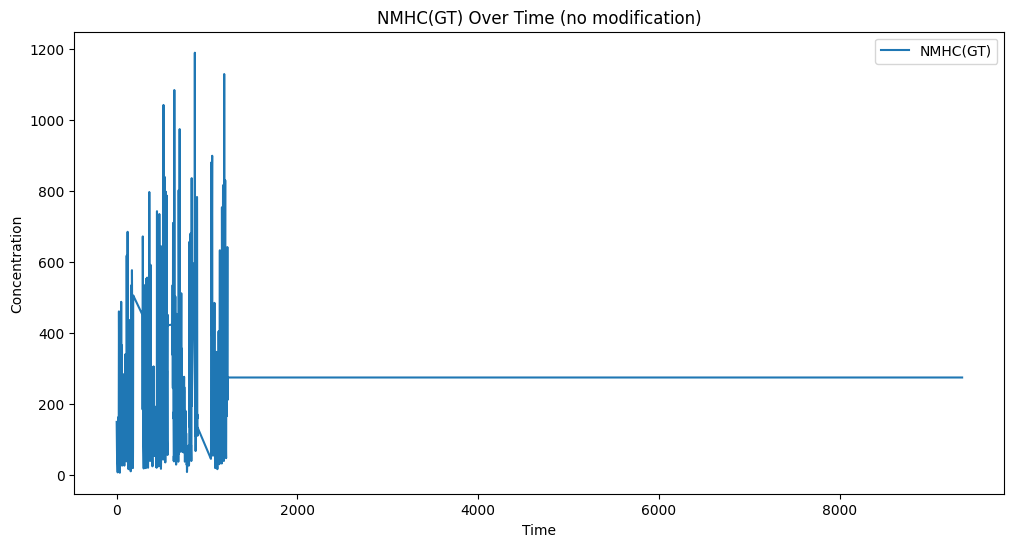

In [ ]:
plt.figure(figsize=(12,6))
# for i in range(len(sensor_cols)):
#   plt.plot(sensors[sensor_cols[i]], label=sensor_cols[i])
plt.plot(sensors['NMHC(GT)'], label='NMHC(GT)')
plt.title("NMHC(GT) Over Time (no modification)")
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.legend()
plt.show()